# Classifier Notebook
### Questions

### Useful links

## Load rawcounts and normalized_logcounts

In [1]:
import scanpy as sc

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import pandas as pd

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

import pickle
import numpy as np


### Read data in

In [2]:
adata = sc.read_h5ad('../sc_training.h5ad')
adata.layers['normalized_logcounts'] = adata.X.copy()
adata.X = adata.layers['rawcounts'].copy()  

sc.pp.normalize_total(adata, target_sum=5e3)
sc.pp.log1p(adata)

In [3]:
normdf = adata.to_df(layer="normalized_logcounts")

In [4]:
normdf.head()

,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,4732440D04Rik,Pcmtd1,Gm26901,Rrs1,Adhfe1,...,Slc3a1,Cfap53,Pstpip2,Gm17227,Ms4a8a,9130016M20Rik,Htr7,Col17a1,Awat2,Amot
053l1_AAACCTGAGATGTCGG-1,0.511520,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACCTGAGCAACGGT-1,0.484165,0.484165,0.808991,0.0,0.0,0.0,0.000000,0.0,0.484165,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACCTGAGTACGACG-1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.693748,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACCTGAGTCGTTTG-1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACCTGAGTGAAGAG-1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
adata.obs['state'] #labels

053l1_AAACCTGAGATGTCGG-1    terminal exhausted
053l1_AAACCTGAGCAACGGT-1              effector
053l1_AAACCTGAGTACGACG-1              effector
053l1_AAACCTGAGTCGTTTG-1    terminal exhausted
053l1_AAACCTGAGTGAAGAG-1              effector
                                   ...        
053l4_TTTGTCATCAGGTTCA-1                 other
053l4_TTTGTCATCAGTGTTG-1               cycling
053l4_TTTGTCATCCTCGCAT-1               cycling
053l4_TTTGTCATCTTCAACT-1               cycling
053l4_TTTGTCATCTTTCCTC-1               cycling
Name: state, Length: 28697, dtype: category
Categories (5, object): ['cycling', 'effector', 'other', 'progenitor', 'terminal exhausted']

## Filter out low variance genes (see EDA)
- Todo: save variance filtered set as another piece of adata

In [13]:
var_per_gene = normdf.var(axis = 0)

In [14]:
filt = var_per_gene[var_per_gene >= ((var_per_gene.sort_values()[-1:][0])/100)]

In [15]:
X = normdf.filter(filt.index.values, axis = 1)

In [16]:
def filter(normdf):
    var_per_gene = normdf.var(axis = 0)
    filt = var_per_gene[var_per_gene >= ((var_per_gene.sort_values()[-1:][0])/100)]
    X = normdf.filter(filt.index.values, axis = 1)
    return X

## Separate samples by perturbation class

In [18]:
df_cond = pd.DataFrame(adata.obs['condition'])
unpert_sample_in = df_cond[df_cond['condition'] == 'Unperturbed'].index

In [19]:
df_unpert = normdf.filter(unpert_sample_in, axis = 0)
df_unpert.head() 

,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,4732440D04Rik,Pcmtd1,Gm26901,Rrs1,Adhfe1,...,Slc3a1,Cfap53,Pstpip2,Gm17227,Ms4a8a,9130016M20Rik,Htr7,Col17a1,Awat2,Amot
053l1_AAACCTGAGATGTCGG-1,0.511520,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACCTGAGTGTTAGA-1,0.000000,1.089103,0.686024,0.686024,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACCTGCATAGACTC-1,0.292065,0.292065,0.292065,0.292065,0.292065,0.0,0.0,0.0,0.292065,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACGGGAGTGGAGAA-1,1.020401,1.020401,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
053l1_AAACGGGCAATCGAAA-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
df_unpert_labels = adata.obs['state'].filter(unpert_sample_in, axis = 0)

In [21]:
filter(df_unpert).head()

,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,Pcmtd1,Rrs1,Vcpip1,Snhg6,Cops5,...,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,CAAA01118383.1,Vamp7,CAAA01147332.1,AC149090.1
053l1_AAACCTGAGATGTCGG-1,0.511520,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,1.610826,1.099769,0.000000,0.000000,1.736030,0.000000,0.0,0.000000,0.0
053l1_AAACCTGAGTGTTAGA-1,0.000000,1.089103,0.686024,0.686024,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.686024,1.375591,0.686024,0.000000,0.686024,1.779859,0.686024,0.0,0.000000,0.0
053l1_AAACCTGCATAGACTC-1,0.292065,0.292065,0.292065,0.292065,0.292065,0.0,0.292065,0.0,0.0,0.517829,...,0.517829,2.135607,1.216197,1.479762,0.000000,2.284313,0.292065,0.0,0.292065,0.0
053l1_AAACGGGAGTGGAGAA-1,1.020401,1.020401,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,1.020401,0.000000,0.000000,1.844182,0.000000,0.0,1.020401,0.0
053l1_AAACGGGCAATCGAAA-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,1.836899,2.187799,2.187799,0.000000,0.000000,2.187799,0.000000,0.0,0.000000,0.0


## SVM
- **unperturbed cells data only**

In [14]:
X_train, X_test, y_train, y_test = train_test_split(filter(df_unpert), df_unpert_labels, test_size=.2, random_state=88)
svc = SVC(gamma = 1e-3, C = 100) #auto = 1/n_features, scale = 1/(n_features * variance(X)), used these values based on gridsearch
svc.fit(X_train, y_train)


SVC(C=100, gamma=0.001)

In [15]:
preds = svc.predict(X_test)
cm = confusion_matrix(y_test, preds)

In [17]:
filename = 'svc_model_unperturbed.sav'
pickle.dump(svc, open(filename, 'wb'))

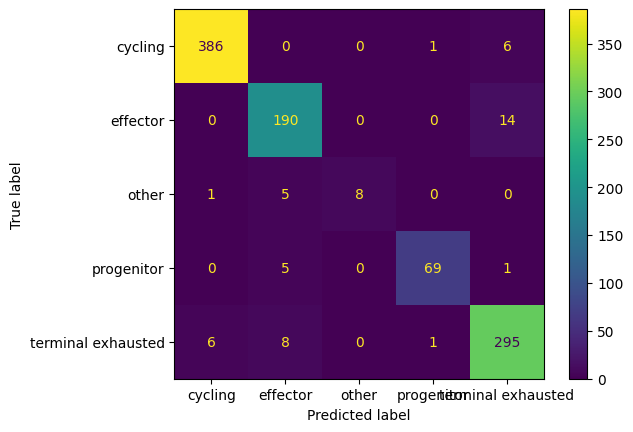

In [84]:
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= svc.classes_).plot()

#plt.savefig('../graphs/cm_plot_svm.png')
plt.show()

In [16]:
print(svc.classes_)
f1_score(y_test, preds, average=None)


['cycling' 'effector' 'other' 'progenitor' 'terminal exhausted']


array([0.9821883 , 0.9223301 , 0.72727273, 0.94520548, 0.94249201])

**Are these the best hyperparameters? Check a wide range via GridSearch**

In [24]:
#this takes a million years to run
X_train, X_test, y_train, y_test = train_test_split(filter(df_unpert), df_unpert_labels, test_size=.2, random_state=88)
parameters = {'kernel':['rbf'], 'C':[1e-1, 1, 1e2, 1e3], 'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2]}
#parameters = {'kernel':['rbf'], 'C':[1e-1, 1], 'gamma': [1e-3]}
svc = SVC()
clf = GridSearchCV(estimator = svc, param_grid = parameters, n_jobs=-1, verbose=3)
clf.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 100.0, 1000.0],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 100.0],
                         'kernel': ['rbf']},
             verbose=3)

In [41]:
clf.best_estimator_

SVC(C=100.0, gamma=0.0001)

In [ ]:
#cv = pd.DataFrame(clf.cv_results_)
#cv.to_csv('svm_gridsearch_results.csv') #saved the results

### Does the SVM trained on unperturbed data translate well to the perturbseq data?

In [23]:
#note that filter(normdf) won't work bc the genes filtered out are based on variance of unperturbed cells. Instead, use a mask to get the same genes
normdf[filter(df_unpert).columns].head()

,Mrpl15,Lypla1,Tcea1,Atp6v1h,Rb1cc1,Pcmtd1,Rrs1,Vcpip1,Snhg6,Cops5,...,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,CAAA01118383.1,Vamp7,CAAA01147332.1,AC149090.1
053l1_AAACCTGAGATGTCGG-1,0.511520,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.610826,1.099769,0.000000,0.0,1.736030,0.0,0.0,0.000000,0.000000
053l1_AAACCTGAGCAACGGT-1,0.484165,0.484165,0.808991,0.0,0.0,0.000000,0.484165,0.000000,0.484165,0.808991,...,0.484165,0.808991,1.053775,0.000000,0.0,2.060644,0.0,0.0,1.053775,0.000000
053l1_AAACCTGAGTACGACG-1,0.000000,0.000000,0.000000,0.0,0.0,0.693748,0.000000,0.000000,0.000000,0.000000,...,0.693748,0.693748,1.099413,0.000000,0.0,1.610399,0.0,0.0,0.000000,1.099413
053l1_AAACCTGAGTCGTTTG-1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.923451,0.000000,1.923451,0.0,1.923451,0.0,0.0,0.000000,0.000000
053l1_AAACCTGAGTGAAGAG-1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.617566,0.000000,0.000000,...,0.617566,1.943172,0.000000,1.270666,0.0,2.058635,0.0,0.0,0.617566,0.996512


0.9578397212543553 rb


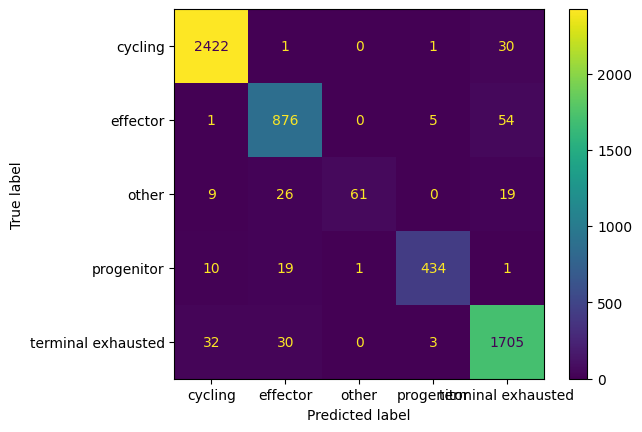

In [29]:
#split the full perturb seq dataset into test and train
X_train, X_test, y_train, y_test = train_test_split(normdf[filter(df_unpert).columns], adata.obs['state'], test_size=.2, random_state=88)

#load the pretrained model
loaded_model = pickle.load(open('../saved_models/svc_model_unperturbed.sav', 'rb'))
result = loaded_model.score(X_test, y_test)
print(result, 'rb')
preds = loaded_model.predict(X_test)


cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= loaded_model.classes_).plot()

plt.show()

In [30]:
print(svc.classes_)
f1_score(y_test, preds, average=None)

['cycling' 'effector' 'other' 'progenitor' 'terminal exhausted']


array([0.98295455, 0.9279661 , 0.68926554, 0.95594714, 0.95278011])

### Compare the distribution between "fake" perturbseq data and "real" perturbseq data
unperturbed cells > normalize > subset to high variance genes used for training > for every gene in real perturbseq data (~70), find subset of zero expression data cells (create "fake" perturbseq data) > use SVM trained on all unperturbed data and predict "fake" perturbseq data and "real" perturb seq data > compare distributions

In [15]:
df_unpert
pert = adata.obs.condition.values.unique()[1::]
pert

['Tox2', 'Tpt1', 'Tcf7', 'Il12rb1', 'Ikzf3', ..., 'Myb', 'Eef2', 'Batf', 'Tbx21', 'Rps6']
Length: 66
Categories (67, object): ['Arid4b', 'Arid5b', 'Atf2', 'Batf', ..., 'Unperturbed', 'Yy1', 'Zeb2', 'Zfp292']

In [53]:
def gene_of_interest(df, gene_list):
    means = []
    columns = []
    stds = []
    counts = []
    mean = df.mean()
    std = df.std()
    for p in gene_list: 
        if sum(df.columns.str.contains(p)) > 0 : #only continue if the gene of interest exists
            columns.append(p)
            means.append(mean[p])
            stds.append(std[p])
            count = df[[p]][df[p] == 0].count()[0]
            counts.append(count)
    
    df_sum = pd.DataFrame([means,stds,counts], columns = columns, index = ['mean', 'std', 'no_expr_cells']).T
    df_sum['no_expr/total_cell'] = df_sum['no_expr_cells']/df_unpert.shape[0]
    return df_sum

In [54]:
df_sum = gene_of_interest(df_unpert, pert)

In [55]:
df_sum #note that this is without the low variance genes filtered out

,mean,std,no_expr_cells,no_expr/total_cell
Tox2,0.003892,0.048401,4939.0,0.992166
Tpt1,3.142531,0.281822,0.0,0.000000
Tcf7,0.039141,0.196676,4727.0,0.949578
Il12rb1,0.083390,0.195319,4001.0,0.803736
Ikzf3,0.328221,0.395213,2394.0,0.480916
...,...,...,...,...
Myb,0.099169,0.222156,3893.0,0.782041
Eef2,2.357720,0.372067,21.0,0.004219
Batf,0.304883,0.369247,2434.0,0.488951
Tbx21,0.456430,0.436335,1770.0,0.355564


In [56]:
def gene_of_interest_df(df, gene_list):
    pert_dfs = []
    for p in gene_list: 
        if sum(df.columns.str.contains(p)) > 0 : #only continue if the gene of interest exists
            df_subset = df[df[p] == 0]
            pert_dfs.append(df_subset)
    return pert_dfs

In [57]:
pert_dfs = gene_of_interest_df(df_unpert, pert)

In [71]:
#still need to filter out low variance genes
print(pert)
label_subset = pd.DataFrame(adata.obs['state']).filter(pert_dfs[4].index.values, axis = 0)

['Tox2', 'Tpt1', 'Tcf7', 'Il12rb1', 'Ikzf3', ..., 'Myb', 'Eef2', 'Batf', 'Tbx21', 'Rps6']
Length: 66
Categories (67, object): ['Arid4b', 'Arid5b', 'Atf2', 'Batf', ..., 'Unperturbed', 'Yy1', 'Zeb2', 'Zfp292']


### Test distributions with "Ikzf3"

In [33]:
X_train, X_test, y_train, y_test = train_test_split(filter(df_unpert), df_unpert_labels, test_size=.2, random_state=88) #only subset the test data to prevent data bleeding

goi_df= X_test[X_test['Ikzf3'] == 0]
goi_labels = y_test.filter(goi_df.index.values, axis = 0)

0.9362549800796812 rb


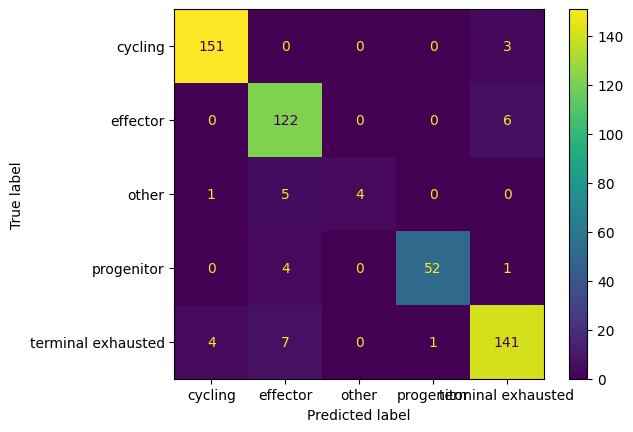

['cycling' 'effector' 'other' 'progenitor' 'terminal exhausted']


array([0.97419355, 0.91729323, 0.57142857, 0.94545455, 0.92763158])

In [34]:
#use only data that you didn't train on to predict the distributions
loaded_model = pickle.load(open('../saved_models/svc_model_unperturbed.sav', 'rb'))
result = loaded_model.score(goi_df, goi_labels)
print(result, 'rb')
#result = loaded_model.score(X_test[0:10], y_test[0:10])
preds = loaded_model.predict(goi_df)

cm = confusion_matrix(goi_labels, preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= loaded_model.classes_).plot()

plt.show()

print(loaded_model.classes_)
f1_score(goi_labels, preds, average=None)

In [35]:
confusion_matrix(goi_labels, preds, normalize = 'all')

array([[0.30079681, 0.        , 0.        , 0.        , 0.0059761 ],
       [0.        , 0.24302789, 0.        , 0.        , 0.01195219],
       [0.00199203, 0.00996016, 0.00796813, 0.        , 0.        ],
       [0.        , 0.00796813, 0.        , 0.10358566, 0.00199203],
       [0.00796813, 0.01394422, 0.        , 0.00199203, 0.28087649]])

In [38]:
len(cm)

5

In [56]:
#use the actual perturbseq data for Ikzf3
ikzf3_df = normdf.filter(adata.obs[adata.obs['condition'] == 'Ikzf3'].index.values, axis = 0)[filter(df_unpert).columns] #where Ikzf3 is knocked out in real perturbseq data
ikzf3_labels = pd.DataFrame(adata.obs['state']).filter(ikzf3_df.index.values, axis = 0)

0.9298245614035088 rb


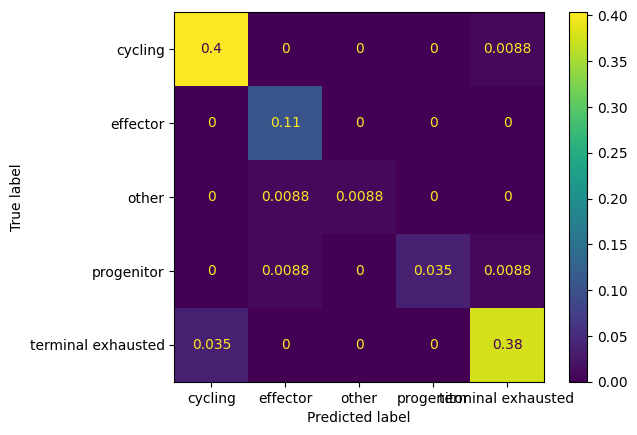

['cycling' 'effector' 'other' 'progenitor' 'terminal exhausted']


array([0.94845361, 0.92307692, 0.66666667, 0.8       , 0.93478261])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(ikzf3_df, ikzf3_labels, test_size=.2, random_state=88)


result = loaded_model.score(X_test, y_test)
print(result, 'rb')
preds = loaded_model.predict(X_test)


cm = confusion_matrix(y_test, preds, normalize = 'all')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= loaded_model.classes_).plot()

plt.show()

print(loaded_model.classes_)
f1_score(y_test, preds, average=None)



In [58]:
cm

array([[0.40350877, 0.        , 0.        , 0.        , 0.00877193],
       [0.        , 0.10526316, 0.        , 0.        , 0.        ],
       [0.        , 0.00877193, 0.00877193, 0.        , 0.        ],
       [0.        , 0.00877193, 0.        , 0.03508772, 0.00877193],
       [0.03508772, 0.        , 0.        , 0.        , 0.37719298]])

KstestResult(statistic=0.4, pvalue=0.873015873015873)


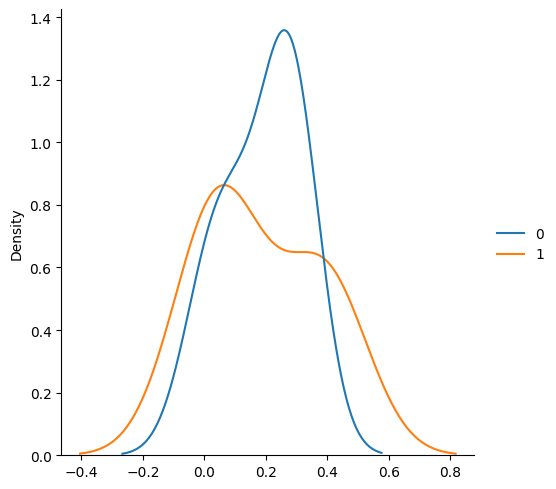

In [61]:
from scipy.stats import ks_2samp
import seaborn as sns
fakep = [0.30079681,  0.24302789, 0.00796813, 0.10358566, 0.28087649]
realp = [0.40350877, 0.10526316, 0.00877193, 0.03508772,  0.37719298]
print(ks_2samp(fakep, realp)) #do not reject the null hypothesis

sns.displot(data=[fakep,realp], label = ['fakep', 'realp'], kind="kde")
plt.show()

### Compare distributions for each perturbation

Overview:
- Each gene in the perturbation list is a gene of interest (GOI).
- Creating "fake" perturbseq data:
- If the exists in the sequences of the condition == unperturbed cell subset, then:
    - isolate cells where that GOI is 0 (not expressed) (call this: gene_of_interest_df)
- The SVM was trained on the unperturbed cells. To prevent data bleeding:
    - From the unseen test data the SVM used, find cells that are also contained in gene_of_interest_df
    - Use the intersection of these data as inputs into the pre-trained SVM
    - subset to only include columns that the SVM was trained on
    - calculate the normalized confusion matrix, f1 score and resulting distribution of tcell values
    
- Test "real" perturbseq data:
    - isolate the cells for which the condition is gene of interest
    - subset to only include gene columns that the SVM was trained on
    - Predict the label of these samples using the same SVM as above that was trained on the unperturbed data
    - calculate the normalized confusion matrix, f1 score and resulting distribution of tcell values
    
- Run KS test on the two distributions
- Plot the displot of each distribution
    
    

In [22]:
#combine perturbation lists to create all genes of interest
pert = adata.obs.condition.values.unique().to_list()
val_pert = ['Aqr', 'Bach2', 'Bhlhe40', 'Ets1', 'Fosb', 'Mafk', 'Stat3']
all_pert = pert + val_pert
print(all_pert[0:5])
print(np.shape(all_pert))

['Unperturbed', 'Tox2', 'Tpt1', 'Tcf7', 'Il12rb1']
(74,)


In [23]:
#create dataframe where the gene of interest does not have expression
def gene_of_interest_df(df, gene_list):
    pert_dfs = []
    gois = []
    for p in gene_list: 
        if sum(df.columns.str.contains(p)) > 0 : #only continue if the gene of interest exists
            df_subset = df[df[p] == 0]
            pert_dfs.append(df_subset)
            gois.append(p)
    return pert_dfs, gois

In [24]:
#create dataframes from unperturbed data that contain only cells with no exprssion for that gene of interest
goi_dfs, gois = gene_of_interest_df(df_unpert, all_pert)


In [25]:
np.shape(gois) #3 perturbation conditions were not in the unperturbed expression dataset

(71,)

In [26]:
#get x_test and y_test and subset to only include cells that have 0 expression
X_train, X_test, y_train, y_test = train_test_split(filter(df_unpert), df_unpert_labels, test_size=.2, random_state=88)

In [44]:
def fake_perturbseq(gene_of_interest, X_test, y_test):
    print(gene_of_interest)
    if gene_of_interest in X_test.columns and X_test[X_test[gene_of_interest] == 0].shape[0] > 0:
        goi_df = X_test[X_test[gene_of_interest] == 0]
        goi_labels = y_test.filter(goi_df.index.values, axis = 0)
        loaded_model = pickle.load(open('../saved_models/svc_model_unperturbed.sav', 'rb'))
        result = loaded_model.score(goi_df, goi_labels)
        print(result, 'rb')
        preds = loaded_model.predict(goi_df)
        cm = confusion_matrix(goi_labels, preds, normalize = 'all')
        print(loaded_model.classes_)
        print(f1_score(goi_labels, preds, average=None))
        if len(cm) < 5: 
            dist = cm
        else:
            dist = [cm[0][0], cm[1][1], cm[2][2], cm[3][3], cm[4][4]]
            print(dist)
    else:
        print('gene of interest not found in columns')
        dist = []
    return dist


In [40]:
fake_perturbseq('Tcf7', X_test, y_test)

Tcf7
0.9521785334750266 rb
['cycling' 'effector' 'other' 'progenitor' 'terminal exhausted']
[0.98331194 0.92574257 0.72727273 0.90909091 0.94212219]


[0.4070138150903294,
 0.19872476089266738,
 0.008501594048884165,
 0.026567481402763018,
 0.31137088204038255]

In [45]:
dists = []
for p in all_pert:
    d = fake_perturbseq(p, X_test, y_test)
    dists.append(d)

Unperturbed
gene of interest not found in columns
Tox2
gene of interest not found in columns
Tpt1
gene of interest not found in columns
Tcf7
0.9521785334750266 rb
['cycling' 'effector' 'other' 'progenitor' 'terminal exhausted']
[0.98331194 0.92574257 0.72727273 0.90909091 0.94212219]
[0.4070138150903294, 0.19872476089266738, 0.008501594048884165, 0.026567481402763018, 0.31137088204038255]
Il12rb1
0.9485570890840652 rb
['cycling' 'effector' 'other' 'progenitor' 'terminal exhausted']
[0.98053097 0.92513369 0.7        0.94366197 0.94117647]
[0.3475533249686324, 0.21706398996235884, 0.00878293601003764, 0.08406524466750313, 0.29109159347553326]
Ikzf3
0.9362549800796812 rb
['cycling' 'effector' 'other' 'progenitor' 'terminal exhausted']
[0.97419355 0.91729323 0.57142857 0.94545455 0.92763158]
[0.300796812749004, 0.24302788844621515, 0.00796812749003984, 0.10358565737051793, 0.28087649402390436]
Nr4a3
0.9466666666666667 rb
['cycling' 'effector' 'other' 'progenitor' 'terminal exhausted']
[0.9

In [48]:
pd.DataFrame(dists).to_csv('distributions_fakepeturb.csv')

In [58]:
pd.DataFrame(dists, columns = ['cycling', 'effector', 'other', 'progenitor', 'terminal exhausted'], index = all_pert)
#pd.DataFrame(dists, columns = ['cycling', 'effector', 'other', 'progenitor', 'terminal exhausted'], index = all_pert).to_csv('distributions_fakepeturb.csv')

,cycling,effector,other,progenitor,terminal exhausted
Unperturbed,None,None,None,None,NaN
Tox2,None,None,None,None,NaN
Tpt1,None,None,None,None,NaN
Tcf7,0.407014,0.198725,0.008502,0.026567,0.311371
Il12rb1,0.347553,0.217064,0.008783,0.084065,0.291092
...,...,...,...,...,...
Bhlhe40,0.188525,0.311475,0.057377,0.057377,0.327869
Ets1,0.225664,0.30531,0.013274,0.10177,0.300885
Fosb,0.360234,0.205848,0.007018,0.063158,0.313450
Mafk,0.386062,0.19469,0.007743,0.06969,0.293142


## SVM
- try with all cells
- result: took too long and didn't give much better results than with just unperturbed cells

[LibSVM]*
optimization finished, #iter = 833
obj = -346.203436, rho = 1.969793
nSV = 827, nBSV = 425
*
optimization finished, #iter = 614
obj = -377.217110, rho = 2.115924
nSV = 663, nBSV = 417
*
optimization finished, #iter = 739
obj = -572.718064, rho = 0.356239
nSV = 1023, nBSV = 786
.
*.*
optimization finished, #iter = 2264
obj = -2138.812131, rho = 3.406305
nSV = 3378, nBSV = 2835
*
optimization finished, #iter = 677
obj = -381.154560, rho = 0.631350
nSV = 720, nBSV = 426
*
optimization finished, #iter = 880
obj = -525.600201, rho = -1.757037
nSV = 1015, nBSV = 662
.
*
optimization finished, #iter = 1854
obj = -1846.530409, rho = -3.724617
nSV = 2714, nBSV = 2279
*
optimization finished, #iter = 468
obj = -217.749988, rho = -1.906228
nSV = 493, nBSV = 272
*
optimization finished, #iter = 825
obj = -411.304498, rho = -1.617644
nSV = 761, nBSV = 405
*
optimization finished, #iter = 827
obj = -515.484101, rho = -0.012983
nSV = 988, nBSV = 672
Total nSV = 8714


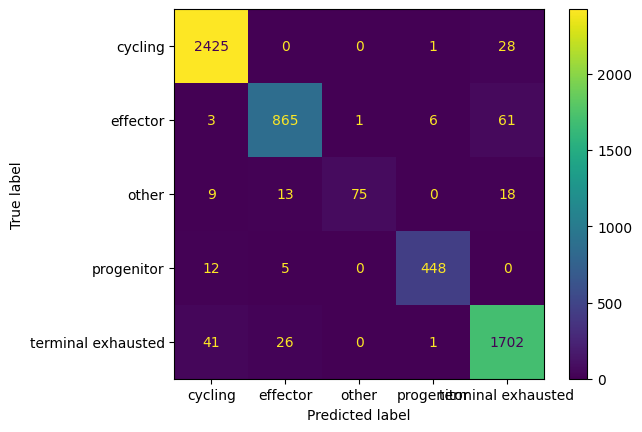

In [31]:
#takes a long time like 1.5 hours
X_train, X_test, y_train, y_test = train_test_split(filter(normdf), adata.obs['state'], test_size=.2, random_state=88)
svc = SVC(gamma = 'auto', C = 1, verbose = 3) #auto = 1/n_features, scale = 1/(n_features * variance(X))
svc.fit(X_train, y_train)
preds = svc.predict(X_test)
cm = confusion_matrix(y_test, preds)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= svc.classes_).plot()

#plt.savefig('../graphs/cm_plot_svm_all.png')
plt.show()

### save all cells svm model, which takes a long time to train

In [1]:
filename = 'svc_model_allcells.sav'
pickle.dump(svc, open(filename, 'wb'))

In [ ]:
#load model for use, but the predict feature takes really long like hours
loaded_model = pickle.load(open('../saved_models/svc_model_allcells.sav', 'rb'))
result = loaded_model.score(X_test, y_test)
print(result, 'rb')
#result = loaded_model.score(X_test[0:10], y_test[0:10])
preds = loaded_model.predict(X_test)


cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= loaded_model.classes_).plot()

plt.show()

In [9]:
print(svc.classes_)
f1_score(y_test, preds, average=None)

['cycling' 'effector' 'other' 'progenitor' 'terminal exhausted']


array([0.98119312, 0.92720307, 0.72222222, 0.96641387, 0.94868239])

Ideas for next steps:
- grid search with the full data set to find optimal C and gamma
    - classifier is good enough, hoping the misclassifications go into other categories at the same rate
- why is the model so slow?
- eda exploration of "other" category
    - heatmap suggests that misclassification of effector and other should be expected, since those categories are the most closely related when looking at the expression values of cells in those categories
- consider 1 page write up, check misclassified cells
- check how paper did preprocessing for t cell categorization

## Where are the misclassified points? At the edges of clusters?
- Not finished, but consider that in 2D or 3D the dimensions at which the points were at the "edge" of clusters may not be the ones you are visualizing (since it is a lower dimensional embedding of what the data actually is)

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata, min_dist=0.3) 
sc.pl.umap(adata, color=['state'], palette='Accent', legend_loc='right margin')

## XGBoost

Didn't work well, see Sam's explanation from slack:

Amanda: "Long math/model intuition question coming through 
What I understand is SVM is a linear separation of groups technique so if I look at low dimensional representation of the samples and color by label and it’s hard to separate the groups with a line (or plane) by eye I would move away from SVM
I guess the UMAP showed that the groups are separable when colored by label but they also overlap a fair amount?
Is this the right way to think about SVM and linear/ log regression?
I also ran PCA and even with 50 components only about 20% of the variance is described, so I thought going toward more complex models would be good
These thoughts led me to try XGBoost first, but out of the box without tuning much that turned out pretty badly (very low accuracy)
When this turned out badly my first thought was let’s tune it/ it’s probably a more complex relationship than we thought!
The fact that SVM worked well makes me think this thought processes is wrong.
What’s the flaw in my thought process? If we didn’t see that the paper had successfully tried SVM is there a reason from the PCA/ UMAP embeddings that it would be a reasonable model to try first?"

Sam: "Great questions! First, the UMAP embedding forces the data into 2 dimensions, where everything is harder to separate. When you have a 15K dimensional hyperplane at your disposal, it gets much easier to separate arbitrary sets of points. (Thought experiment - if you have 4 points in a square to separate into two groups, there are group configurations that aren't linearly separable. What if the 4 points are instead non-co-planar vertices of a cube?)
Second, SVM's are mathematically based on linear separators, but by manipulating the way we compute distances (the "kernel trick", to use the term slightly inaccurately), we can achieve separations that correspond to, equivalently, projecting the data into higher dimensions or achieving nonlinear separation boundaries. The SVM with a Radial Basis Function (RBF) kernel is generally accepted to be the best off-the-shelf classifier for new datasets. (There are cases where defining a distance metric is unwieldy, like with images, or where there is a large amount of tangentially-related data that might make the problem easier, like with images, but for most datasets where # data points > # dimensionality of the data, SVM is a phenomenal go-to.)
Re: Data Complexity
That does sound like it's pretty long-tailed, so I'm inclined to say that the generative model will need to be large and fairly unstructured. Re: XGBoost - my understanding is that XGBoost uses shallow decision trees as its default classifiers, which do much worse at very high dimensionality than hyperplanes (the hyperplanes have way more free parameters), so I would imagine that the number of iterations needed would be enormous, and the computational costs usually grow quadratically with the number of iterations."


Already tried:
- filtering genes out by variance didn't improve the accuracy much (~42%)
- increasing estimator number didn't improve accuracy much (50 -> 100 ~42%)
- train on unperturbed data only: accuracy worse lol (39%), maybe bc less data?

In [99]:
X_train, X_test, y_train, y_test = train_test_split(filter(df_unpert), df_unpert_labels, test_size=.2, random_state=88)

In [100]:
bst = XGBClassifier(n_estimators=100, max_depth=0, learning_rate=0.2, objective='binary:logistic')
# fit model
bst.fit(X_train, y_train)
# make predictions
preds = bst.predict(X_test)

[21:23:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [101]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 39.46%


In [ ]:
>>> from sklearn.model_selection import GridSearchCV
>>> iris = datasets.load_iris()
>>> parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
>>> svc = svm.SVC()
>>> clf = GridSearchCV(svc, parameters)
>>> clf.fit(iris.data, iris.target)
GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})